# Exploratory Data Analysis
Exploratory Data Analysis (EDA) is a critical step to understand the structure, quality, and patterns in the dataset before applying any modeling or forecasting. EDA serves two main purposes in this project:
 - Verify the accuracy of the cleaned dataset, check for anomalies, and confirm that the transformations performed during data preparation produced the intended structure.
 - Identify historical trends in emissions and removals, analyze their relationship with business metrics (revenue, market cap, employees), and evaluate progress toward Apple’s 2030 net-zero target.

In [112]:
# 1. Load data from SQLite
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path



# Connect to your SQLite database
DB_PATH = r"C:\Users\sunit\Desktop\Datasets\apple_emission\emission.db"

with sqlite3.connect(DB_PATH) as conn:
    df = pd.read_sql_query("""
        SELECT * FROM yearly_summary
        ORDER BY year;
    """, conn)

print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   8 non-null      int64  
 1   total_gross_tonnes     8 non-null      float64
 2   total_removals_tonnes  5 non-null      float64
 3   total_net_tonnes       8 non-null      float64
 4   revenue_usd_b          8 non-null      float64
 5   market_cap_usd_b       8 non-null      float64
 6   employees              8 non-null      float64
 7   iphone_baseline_kg     8 non-null      float64
dtypes: float64(7), int64(1)
memory usage: 644.0 bytes
None
   year  total_gross_tonnes  total_removals_tonnes  total_net_tonnes  \
0  2015          38383470.0                    NaN        38383470.0   
1  2016          29579370.0                    NaN        29579370.0   
2  2017          27416300.0                    NaN        27416300.0   
3  2018          25136170.0     

In [113]:
# 2.  Basic Data Quality Check
# Missing Values
print(df.isnull().sum())

year                     0
total_gross_tonnes       0
total_removals_tonnes    3
total_net_tonnes         0
revenue_usd_b            0
market_cap_usd_b         0
employees                0
iphone_baseline_kg       0
dtype: int64


In [114]:
missing_removals = pd.read_sql_query("""
        SELECT year, total_removals_tonnes
        FROM yearly_summary
        WHERE total_removals_tonnes IS NULL
        ORDER BY year;
    """, conn)

missing_removals

,year,total_removals_tonnes
0,2015,None
1,2016,None
2,2017,None


In [115]:
# Duplicates by year
dupes = df.duplicated(subset=["year"]).sum()
print("Duplicate years:", dupes)


Duplicate years: 0


In [116]:
 #Simple range sanity
print("Years:", df["year"].min(), "→", df["year"].max())

Years: 2015 → 2022


In [117]:
# Ensure numeric columns are numeric (just in case)
num_cols = [c for c in df.columns if c != "year"]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

We observe that the column total_removals_tonnes has 3 missing values, corresponding to the years 2015, 2016, and 2017. These correspond to the years in which Apple did not report any measurable carbon removals. Since these are genuine non-reported values rather than data entry errors, we will leave them as NaN instead of imputing values.

In [118]:
# 3. Create derived metrices(intensities)
# Guard against division by zero/NaN
if "revenue_usd_b" in df.columns:
    df["emissions_per_$B_revenue_gross"] = df["total_gross_tonnes"] / df["revenue_usd_b"]
if "employees" in df.columns:
    df["emissions_per_employee_gross"] = df["total_gross_tonnes"] / df["employees"]
if "market_cap_usd_b" in df.columns:
    df["emissions_per_$B_mktcap_gross"] = df["total_gross_tonnes"] / df["market_cap_usd_b"]


To better understand Apple’s emissions in relation to its business scale, we calculated emissions intensities metrics that show emissions per unit of economic or operational output. These derived metrics normalize gross emissions against:

- Revenue ($B) – measures carbon efficiency relative to sales performance.

- Employees – gauges emissions per staff member, linking workforce size to environmental impact.

- Market Capitalization ($B) – indicates emissions per market value, useful for comparing sustainability performance to corporate valuation.

By using these ratios, we can identify whether Apple’s emissions reductions are keeping pace with business growth, even if absolute emissions are declining more slowly.

In [119]:
# 4. Core KPIS: 2015 to 2022 change
import numpy as np

def pick(col, year):
    return float(df.loc[df["year"] == year, col].iloc[0])

y0, y1 = 2015, 2022
kpis = {}
for col in ["total_gross_tonnes","total_net_tonnes","total_removals_tonnes",
            "revenue_usd_b","market_cap_usd_b","employees","iphone_baseline_kg"]:
    if col in df.columns:
        kpis[col] = {
            "2015": pick(col, y0),
            "2022": pick(col, y1),
            "abs_change": pick(col, y1) - pick(col, y0),
            "pct_change": (pick(col, y1) / pick(col, y0) - 1) * 100
        }

pd.DataFrame(kpis).T



,2015,2022,abs_change,pct_change
total_gross_tonnes,38383470.0,20604000.0,-17779470.0,-46.320643
total_net_tonnes,38383470.0,20279900.0,-18103570.0,-47.165017
total_removals_tonnes,NaN,-324100.0,NaN,NaN
revenue_usd_b,233715.0,394328.0,160613.0,68.721734
market_cap_usd_b,580.0,2490.0,1910.0,329.310345
employees,110000.0,164000.0,54000.0,49.090909
iphone_baseline_kg,54.0,61.0,7.0,12.962963


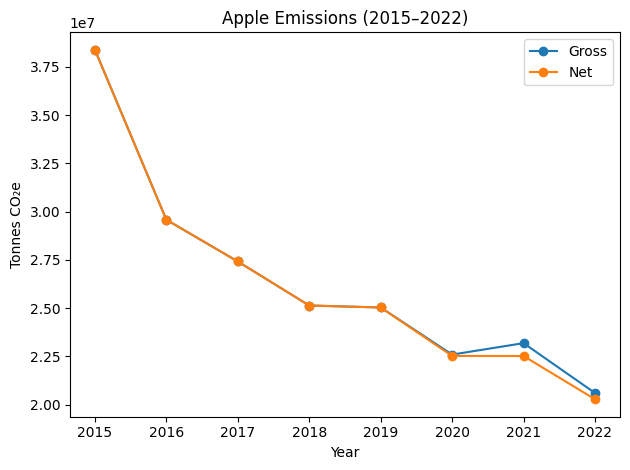

In [120]:
# 5.  Visuals (matplotlib)
# Gross vs Net emissions
plt.figure()
plt.plot(df["year"], df["total_gross_tonnes"], marker="o", label="Gross")
plt.plot(df["year"], df["total_net_tonnes"], marker="o", label="Net")
plt.title("Apple Emissions (2015–2022)")
plt.xlabel("Year"); plt.ylabel("Tonnes CO₂e"); plt.legend(); plt.tight_layout(); plt.show()



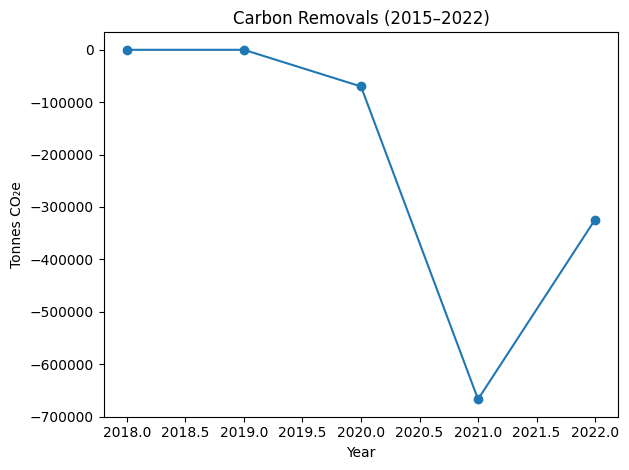

In [121]:
# Removals trend
if "total_removals_tonnes" in df.columns:
    plt.figure()
    plt.plot(df["year"], df["total_removals_tonnes"], marker="o")
    plt.title("Carbon Removals (2015–2022)")
    plt.xlabel("Year"); plt.ylabel("Tonnes CO₂e"); plt.tight_layout(); plt.show()



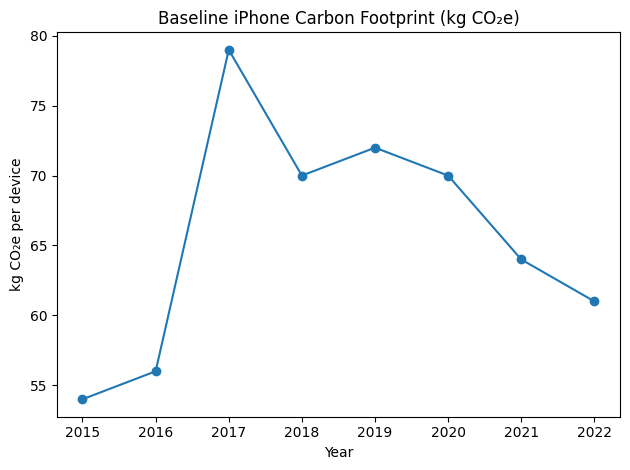

In [122]:
# Baseline iPhone footprint
if "iphone_baseline_kg" in df.columns:
    plt.figure()
    plt.plot(df["year"], df["iphone_baseline_kg"], marker="o")
    plt.title("Baseline iPhone Carbon Footprint (kg CO₂e)")
    plt.xlabel("Year"); plt.ylabel("kg CO₂e per device"); plt.tight_layout(); plt.show()



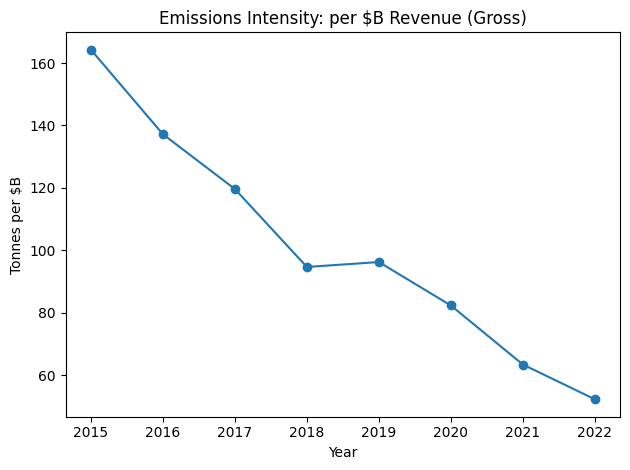

In [123]:
# Intensities per revenue
if "emissions_per_$B_revenue_gross" in df.columns:
    plt.figure()
    plt.plot(df["year"], df["emissions_per_$B_revenue_gross"], marker="o")
    plt.title("Emissions Intensity: per $B Revenue (Gross)")
    plt.xlabel("Year"); plt.ylabel("Tonnes per $B"); plt.tight_layout(); plt.show()



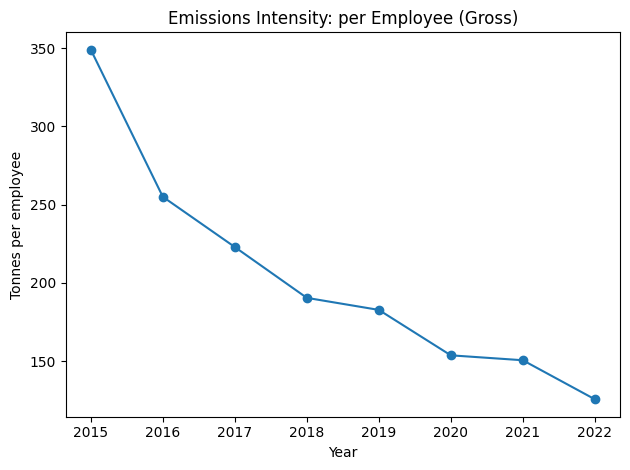

In [124]:
# Intensities per employees
if "emissions_per_employee_gross" in df.columns:
    plt.figure()
    plt.plot(df["year"], df["emissions_per_employee_gross"], marker="o")
    plt.title("Emissions Intensity: per Employee (Gross)")
    plt.xlabel("Year"); plt.ylabel("Tonnes per employee"); plt.tight_layout(); plt.show()


Between 2015 and 2022, Apple achieved a 46.3% reduction in gross emissions and a 47.2% reduction in net emissions, demonstrating meaningful progress toward decarbonization. However, total carbon removals in 2015 were not recorded, so percentage change for that metric cannot be computed.

Over the same period, Apple’s revenue grew by 68.7%, market capitalization surged by over 329%, and employee count increased by 49.1%. This shows that the company significantly expanded its business while reducing its total carbon footprint—an encouraging sign of decoupling growth from emissions.

At the product level, the baseline iPhone carbon footprint increased by 13%, suggesting that product-level efficiency improvements have not fully matched corporate-level emission reductions and may require more targeted efforts.

In [125]:
# 6. Share of removals and net z vs gross
df["removals_share_of_gross_%"] = np.where(df["total_gross_tonnes"]!=0,
                                           df["total_removals_tonnes"] / df["total_gross_tonnes"] * 100, np.nan)
df[["year","total_gross_tonnes","total_removals_tonnes","total_net_tonnes","removals_share_of_gross_%"]]



,year,total_gross_tonnes,total_removals_tonnes,total_net_tonnes,removals_share_of_gross_%
0,2015,38383470.0,NaN,38383470.0,NaN
1,2016,29579370.0,NaN,29579370.0,NaN
2,2017,27416300.0,NaN,27416300.0,NaN
3,2018,25136170.0,0.0,25136170.0,0.000000
4,2019,25033730.0,0.0,25033730.0,0.000000
5,2020,22594440.0,-70000.0,22524440.0,-0.309811
6,2021,23186400.0,-667000.0,22519400.0,-2.876686
7,2022,20604000.0,-324100.0,20279900.0,-1.572996


scope  Outside scopes (removals)  Scope 1  Scope 2 (market-based)     Scope 3
year                                                                         
2015                         0.0  28100.0                 42460.0  38312910.0
2016                         0.0  34370.0                 41000.0  29504000.0
2017                         0.0  47050.0                 36250.0  27333000.0
2018                         0.0  57440.0                  8730.0  25070000.0
2019                         0.0  52730.0                     0.0  24981000.0
2020                    -70000.0  47440.0                     0.0  22547000.0
2021                   -667000.0  55200.0                  2780.0  23128420.0
2022                   -324100.0  55200.0                  3000.0  20545800.0


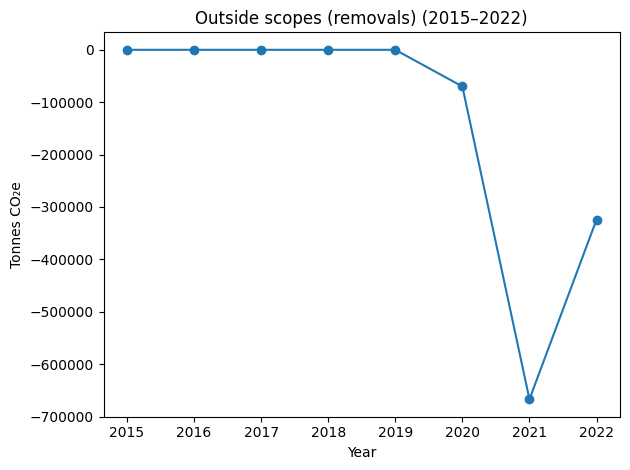

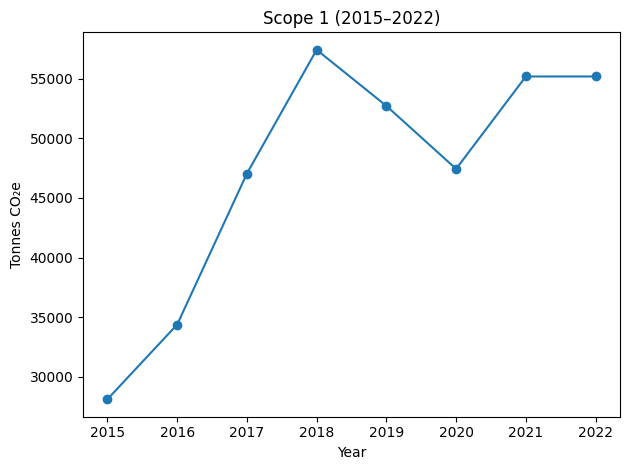

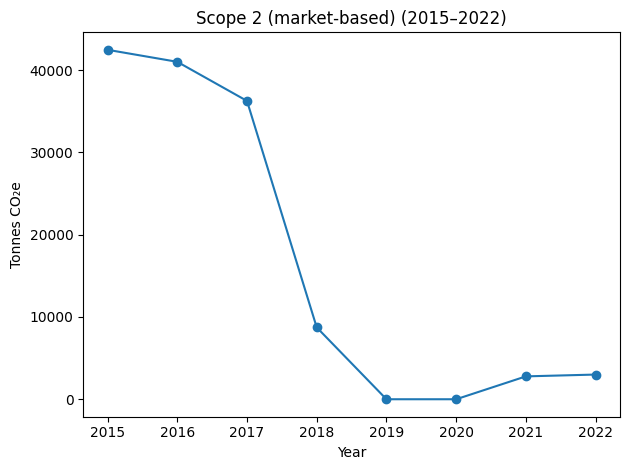

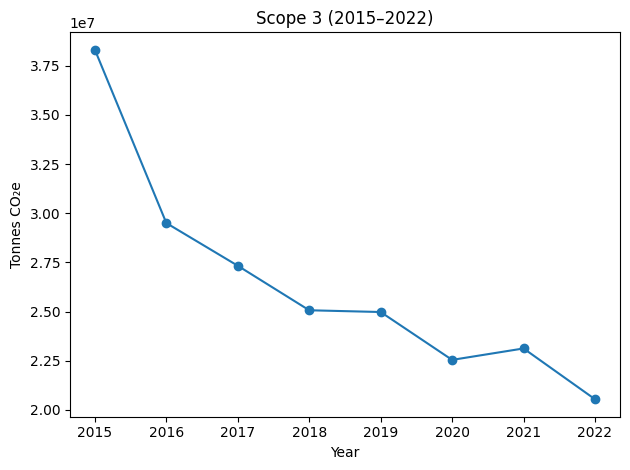

In [126]:

# 8) Pull scope breakdown for deeper EDA
# If you created emissions_labeled in SQL, you can bring a scope time-series:
with sqlite3.connect(DB_PATH) as conn:
    scope_ts = pd.read_sql_query("""
        SELECT year, scope, SUM(emissions_tonnes) AS tonnes
        FROM emissions
        WHERE emissions_tonnes IS NOT NULL
        GROUP BY year, scope
        ORDER BY year, scope;
    """, conn)

scope_ts_pivot = scope_ts.pivot(index="year", columns="scope", values="tonnes").fillna(0)
print(scope_ts_pivot)

# Simple stacked-like look: plot each scope separately
for col in scope_ts_pivot.columns:
    plt.figure()
    plt.plot(scope_ts_pivot.index, scope_ts_pivot[col], marker="o")
    plt.title(f"{col} (2015–2022)")
    plt.xlabel("Year"); plt.ylabel("Tonnes CO₂e"); plt.tight_layout(); plt.show()


From 2015–2022, Apple’s emissions cuts were driven mainly by steady Scope 3 reductions, which dominate its footprint. Scope 2 (market-based) dropped sharply after 2017 to near zero, while Scope 1 rose until 2018 and then declined slightly. Carbon removals were minimal until 2020, spiking in 2021 but easing in 2022. This shows strong progress in Scope 3 and Scope 2, with Scope 1 and removals needing more focus to reach the 2030 net-zero goal.

In [127]:
# 7. Simple projection to 2030 (CAGR-style)
# We’ll project gross and net separately using 2015→2022 trend
def annual_reduction_rate(start, end, n_years):
    if start <= 0 or end <= 0:
        return np.nan
    return 1 - (end / start) ** (1/n_years)

yrs = y1 - y0
gross_start, gross_end = pick("total_gross_tonnes", y0), pick("total_gross_tonnes", y1)
net_start,   net_end   = pick("total_net_tonnes",   y0), pick("total_net_tonnes",   y1)

gross_arr = annual_reduction_rate(gross_start, gross_end, yrs)
net_arr   = annual_reduction_rate(net_start,   net_end,   yrs)
print(f"Annual reduction rate (gross): {gross_arr:.2%}")
print(f"Annual reduction rate (net):   {net_arr:.2%}")

years_ahead = 2030 - y1
gross_2030 = gross_end * ((1 - gross_arr) ** years_ahead) if pd.notna(gross_arr) else np.nan
net_2030   = net_end   * ((1 - net_arr)   ** years_ahead) if pd.notna(net_arr)   else np.nan
print(f"Projected gross emissions 2030: {gross_2030:,.0f} tCO₂e")
print(f"Projected net emissions   2030: {net_2030:,.0f} tCO₂e")




Annual reduction rate (gross): 8.50%
Annual reduction rate (net):   8.71%
Projected gross emissions 2030: 10,119,520 tCO₂e
Projected net emissions   2030: 9,781,484 tCO₂e


This shows whether the comapany is on track for “net zero” by 2030 based on past decline rates. 

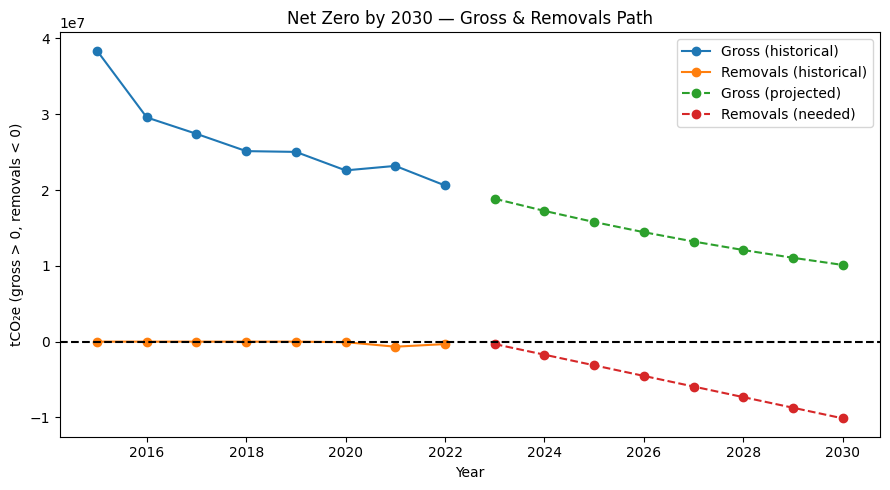

In [128]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Prepare historical data ---
hist = df.sort_values("year").copy()
years_hist = hist["year"].tolist()
gross_hist = hist["total_gross_tonnes"].fillna(0).astype(float).tolist()
rem_hist   = hist["total_removals_tonnes"].fillna(0).astype(float).tolist()

gross_2015 = hist.loc[hist["year"] == 2015, "total_gross_tonnes"].values[0]
gross_2022 = hist.loc[hist["year"] == 2022, "total_gross_tonnes"].values[0]
rem_2022   = hist.loc[hist["year"] == 2022, "total_removals_tonnes"].fillna(0).values[0]

# --- 2. Calculate historical % reduction (2015→2022) ---
gross_change = gross_2022 - gross_2015
gross_pct_change = (gross_change / gross_2015) * 100  # should be about -47%

# --- 3. Annual Reduction Rate (ARR) ---
years_between = 2022 - 2015
gross_arr = 1 - (gross_2022 / gross_2015) ** (1 / years_between)

# --- 4. Project to 2030 (Net Zero scenario) ---
years_future = list(range(2023, 2031))
gross_target = [gross_2022 * ((1 - gross_arr) ** i) for i in range(1, len(years_future) + 1)]
rem_2030 = -gross_target[-1]  # removals needed in 2030 to offset remaining gross
rem_target = np.linspace(rem_2022, rem_2030, len(years_future))  # gradual increase

# --- 5. Plot ---
plt.figure(figsize=(9,5))
plt.plot(years_hist, gross_hist, "o-", label="Gross (historical)")
plt.plot(years_hist, rem_hist, "o-", label="Removals (historical)")
plt.plot(years_future, gross_target, "o--", label="Gross (projected)")
plt.plot(years_future, rem_target, "o--", label="Removals (needed)")
plt.axhline(0, color="black", linestyle="--")

plt.title("Net Zero by 2030 — Gross & Removals Path")
plt.xlabel("Year")
plt.ylabel("tCO₂e (gross > 0, removals < 0)")
plt.legend()
plt.tight_layout()
plt.show()




In [129]:
# --- 6. Print summary ---
rem_need_t_net = (rem_2030 - rem_2022) / len(years_future)
rem_need_pct_net = (rem_need_t_net / abs(rem_2022)) * 100 if rem_2022 != 0 else float('nan')

print("\nNet Zero by 2030 — Summary")
print(f"  Gross emissions reduced by {abs(gross_pct_change):.2f}% from 2015 to 2022")
print(f"  Observed Gross ARR (2015→2022): {gross_arr:.2%} per year")
print(f"  Projected Gross in 2030: {gross_target[-1]:,.0f} tCO₂e")
print(f"  Removals needed in 2030: {rem_2030:,.0f} tCO₂e")
print(f"  Annual increase in removals: {rem_need_t_net:,.0f} tCO₂e/year")
print(f"  Annual increase in removals as % of 2022 abs: {rem_need_pct_net:.2f}%")



Net Zero by 2030 — Summary
  Gross emissions reduced by 46.32% from 2015 to 2022
  Observed Gross ARR (2015→2022): 8.50% per year
  Projected Gross in 2030: 10,119,520 tCO₂e
  Removals needed in 2030: -10,119,520 tCO₂e
  Annual increase in removals: -1,224,427 tCO₂e/year
  Annual increase in removals as % of 2022 abs: -377.79%


# Conclusion
Our analysis shows that Apple has reduced gross greenhouse gas emissions by ~47% from 2015 to 2022, achieving an average annual reduction rate (ARR) of 8.50%. If this pace continues, gross emissions will fall to about 10.1 million tCO₂e by 2030. However, to achieve net zero, the residual emissions must be fully offset through carbon removals. This means removals must scale from ~0.32 million tCO₂e in 2022 to match the projected 10.1 million tCO₂e in 2030 — requiring an unprecedented increase of ~1.22 million tCO₂e per year, or roughly a 378% annual growth rate from the current baseline.

Reaching this goal will require a dual strategy:

- Accelerating gross emissions reduction beyond the current ARR, targeting high-impact areas in Scope 3 (supply chain and product lifecycle) and maintaining near-zero Scope 2.

- Rapidly scaling carbon removal capacity, diversifying methods such as reforestation, direct air capture, and nature-based solutions to ensure reliable, verifiable offsets.